In [21]:
from pathlib import Path
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
from PIL import Image
import os
import random
import re
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator

gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
  tf.config.experimental.set_memory_growth(gpus[0], True)
  print('Memory growth enabled on gpu', gpus[0])

from IPython.display import clear_output
import matplotlib as mpl
import matplotlib.pyplot as plt

tf.__version__

Memory growth enabled on gpu PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


'2.1.0'

In [2]:
#DATADIR

# dataset_dir = Path() / 'drive' / 'Shared drives' / 'IPCV' / 'dataset'
dataset_dir = Path() / 'dataset'
test_train_val_dir = dataset_dir

train_dir = test_train_val_dir / "train"
test_dir = test_train_val_dir / "test"
val_dir = test_train_val_dir / "val"

checkpoint_path = test_train_val_dir / "checkpoints"
log_path = test_train_val_dir / "logs"

tr = list((train_dir / 'rgb').iterdir())
tt = list((test_dir / 'rgb').iterdir())
v = list((val_dir / "rgb").iterdir())

train_len = len(tr)
test_len = len(tt)
val_len = len(v)

list(zip(
    ('train len', 'test_len', 'val_len'),
    (train_len, test_len, val_len)
))

[('train len', 7234), ('test_len', 2068), ('val_len', 1033)]

In [45]:
#GENERATORS 
SIZE = (512, 512)
BATCH_SIZE = 128
STEPS_TRAIN = np.ceil(train_len / BATCH_SIZE)
STEPS_VAL = np.ceil(val_len / BATCH_SIZE)

def data_gen(folder, batch_size, seed=0):
  c = 0
  
  img_folder = str(folder / 'rgb')
  mask_folder = str(folder / 'seg')

  n = os.listdir(img_folder) #List of training images
  random.seed(seed)
  random.shuffle(n)

  while True:
    img = np.zeros((batch_size, 512, 512, 3)).astype('float')
    mask = np.zeros((batch_size, 512, 512, 1)).astype('float')

    for i in range(c, c+batch_size): 
      train_img = tf.io.read_file(img_folder+'/'+n[i])
      train_img = tf.image.decode_jpeg(train_img, channels=3)
      train_img = tf.image.convert_image_dtype(train_img, tf.float32) / 255
      #train_img = tf.cast(train_img, tf.float32) / 255.0
      train_img = tf.image.resize(train_img, (SIZE[0], SIZE[1]))
      
      img[i-c] = train_img #add to array - img[0], img[1], and so on.

      mask_path = (mask_folder+'/'+n[i]).split(".")[0] + ".png"

      train_mask = tf.io.read_file(mask_path)
      train_mask = tf.image.decode_png(train_mask, channels=1)
      train_mask = tf.image.resize(train_mask, (SIZE[0], SIZE[1]))
      mask[i-c] = train_mask

    c+=batch_size
    if c+batch_size >= len(n):
      c=0
      random.shuffle(n)
                  
    yield img, mask

train_gen, val_gen, test_gen = [None] * 3

def refresh_generators(batch_size=8, seed=0):
  global train_gen, val_gen, test_gen

  train_gen = data_gen(train_dir, batch_size, seed)
  val_gen = data_gen(val_dir, batch_size, seed)
  test_gen = data_gen(test_dir, batch_size, seed)

refresh_generators()

assert all(gen is not None for gen in (train_gen, val_gen, test_gen))

In [64]:
import json

labels = (
    'UNLABELED',
    'wall',
    'floor',
    'cabinet',
    'bed',
    'chair',
    'sofa',
    'table',
    'door',
    'window',
    'bookshelf',
    'picture',
    'counter',
    'blinds',
    'desk',
    'shelves',
    'curtain',
    'dresser',
    'pillow',
    'mirror',
    'floor_mat',
    'clothes',
    'ceiling',
    'books',
    'fridge',
    'tv',
    'paper',
    'towel',
    'shower_curtain',
    'box',
    'whiteboard',
    'person',
    'night_stand',
    'toilet',
    'sink',
    'lamp',
    'bathtub',
    'bag'
)

with open('labels.json') as fp:
  ll = json.load(fp)

IMAGE:  True Mask
LABELS: ['UNLABELED', 'wall', 'floor', 'chair', 'table', 'window', 'curtain', 'lamp']



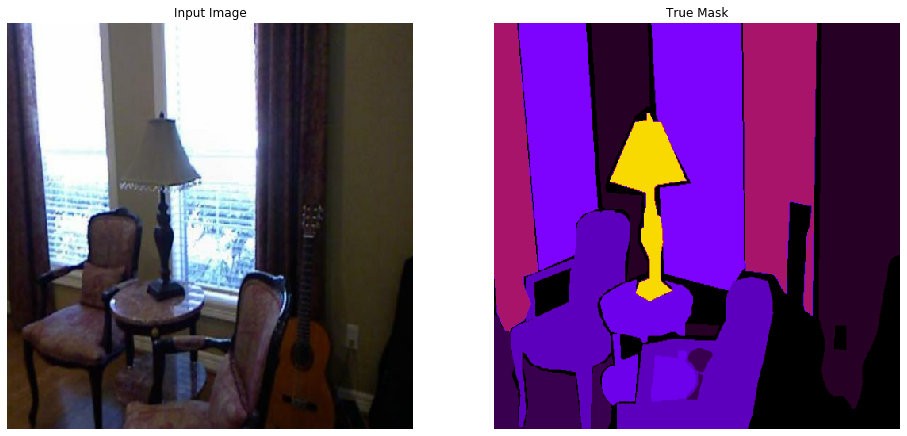

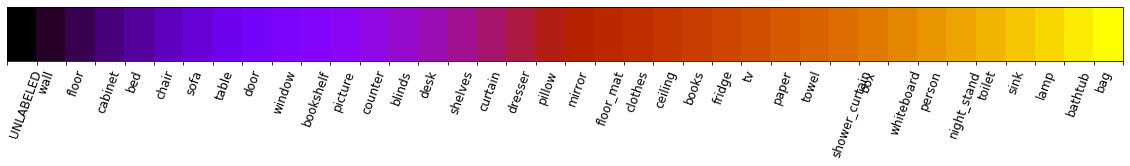

In [65]:
def display(display_list, height=8):
  l = len(display_list)
  assert l < 4, 'Fornire in ingresso al più 3 immagini'

  fig, ax = plt.subplots(1, l, figsize=(height*l, height))
  afig, aax = plt.subplots(1, 1, figsize=(20, 1))
  titles = ['Input Image', 'True Mask', 'Predicted Mask']

  # https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
  # https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.colors.ListedColormap.html
  # ListedColormap per enumerare i colori desiderati
  cmap = mpl.cm.gnuplot
  bounds = np.linspace(0, len(labels), len(labels)+1)
  norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

  labels_dict = dict(zip(range(len(labels)), labels))
  def get_labels(values):
    return [label for key, label in labels_dict.items() if key in values]

  for i in range(l):
    x = display_list[i]
    # il primo controllo non ci fa crashare se abbiamo un'imm a 0 canali (1 implicito)
    # il secondo serve a capire quanti canali ci sono nella terza dim
    rgb = len(x.shape) > 2 and x.shape[2] > 1

    if rgb:
      x = tf.keras.preprocessing.image.array_to_img(x)
    else:
      x = x.reshape((x.shape[0], x.shape[1]))

    title = titles[i]
    ax[i].set_title(title)
    ax[i].imshow(x, cmap=cmap, vmin=0, vmax=len(labels) - 1)
    ax[i].axis('off')
    if not rgb:
      uniques = [e for e in np.unique(x) if np.round(e) == e]
      print('IMAGE: ', title)
      print('LABELS:', get_labels(uniques))
      print()

  cb = mpl.colorbar.ColorbarBase(
    aax, cmap=cmap,
    norm=norm,
    boundaries=bounds,
    ticks=bounds,
    spacing='proportional',
    orientation='horizontal'
  )
  cb.ax.set_xticklabels(labels, rotation=70, size='large', ha='left')

  plt.show()


refresh_generators(seed=20)
image_batch, mask_batch = next(train_gen)
sample_image, sample_mask = image_batch[0], mask_batch[0]
display([sample_image, sample_mask])

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(str((train_dir / "seg").resolve()) + "/img_08439.png")
imgplot = plt.imshow(img)
plt.show()

In [0]:
def down_block(n_filter, kernel, act="relu", dropout_rate=0.1):
  result = tf.keras.Sequential()
  initializer = tf.random_normal_initializer(0., 0.02)

  result.add(tf.keras.layers.Conv2D(n_filter, (kernel, kernel), activation=act, kernel_initializer=initializer,padding='same'))
  #result.add(tf.keras.layers.Dropout(dropout_rate))
  result.add(tf.keras.layers.Conv2D(n_filter, (kernel, kernel), activation=act, kernel_initializer=initializer,padding='same'))
  result.add(tf.keras.layers.BatchNormalization(axis=3, scale=False))
  result.add(tf.keras.layers.MaxPooling2D((2, 2)))

  return result


def up_block(n_filter, kernel, act="relu", dropout_rate=0.2):
  result = tf.keras.Sequential()
  initializer = tf.random_normal_initializer(0., 0.02)

  result.add(tf.keras.layers.UpSampling2D((2, 2)))
  result.add(tf.keras.layers.Conv2D(n_filter, (kernel, kernel), activation=act, kernel_initializer=initializer,padding='same'))
  #result.add(tf.keras.layers.Dropout(dropout_rate))
  result.add(tf.keras.layers.Conv2D(n_filter, (kernel, kernel), activation=act, kernel_initializer=initializer, padding='same'))
  #result.add(tf.keras.layers.BatchNormalization(axis=3, scale=False))
  return result


In [0]:
def down_block_2(n_filter, kernel, act="relu", dropout_rate=0.1):
  result = tf.keras.Sequential()
  initializer = tf.random_normal_initializer(0., 0.02)

  result.add(tf.keras.layers.Conv2D(n_filter, (kernel, kernel), padding='same', kernel_initializer=initializer))
  result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.Activation(act))
  result.add(tf.keras.layers.Conv2D(n_filter, (kernel, kernel), padding='same', kernel_initializer=initializer))
  result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.Activation(act))
  result.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

  return result

def up_block_2(n_filter, kernel, act="relu", dropout_rate=0.2):
  result = tf.keras.Sequential()
  initializer = tf.random_normal_initializer(0., 0.02)

  #result.add(tf.keras.layers.Conv2DTranspose(n_filter, (2, 2), strides=(2, 2), padding='same'))
  result.add(tf.keras.layers.UpSampling2D((2, 2)))
  result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.Activation(act))
  result.add(tf.keras.layers.Conv2D(n_filter, (kernel, kernel), padding='same', kernel_initializer=initializer))
  result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.Activation(act))
  result.add(tf.keras.layers.Conv2D(n_filter, (kernel, kernel), padding='same', kernel_initializer=initializer))
  result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.Activation(act))

  return result


In [0]:
#RESNET
OUTPUT_CHANNELS = 38
base_model = tf.keras.applications.ResNet50V2(input_shape=[128, 128, 3], include_top=False, classes=OUTPUT_CHANNELS)
# Use the activations of these layers
layer_names = [
    'conv1_conv', #64x64
    'conv2_block3_1_relu',   # 32x32
    'conv3_block4_1_relu',   # 16x16
    'conv4_block6_1_relu',   # 8x8
    'conv5_block3_2_relu',  # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False
#base_model.summary()

94674944/94668760 [==============================] - 1s 0us/step


In [0]:

up_stack = [
    up_block(512,3, act="relu"), # 4x4 -> 8x8
    up_block(256,3, act="relu"), # 8x8 -> 16x16
    up_block(128,3, act="relu"), # 16x16 -> 32x32
    up_block(64,3, act="relu"), # 32x32 -> 64x64
    up_block(32,3, act="relu"), # 64x64 -> 128x128
    up_block(16,3, act="relu"), # 128x128 -> 256x256
    up_block(8,3, act="relu"), # 256x256 -> 512x512
]



In [0]:
def unet_model(input_shape, output_channels, ds, us):
  print("UNET MODEL")
  inputs = tf.keras.layers.Input(shape=[input_shape[0], input_shape[1], 3])
  x = inputs
  #x = tf.keras.applications.resnet_v2.preprocess_input(x)
  x = down_block_2(3,3, act="relu")(x)
  first_layer = x
  x = down_block_2(3,3, act="relu")(x)

  # Downsampling through the model
  skips = ds(x)
  skips = [x] + skips#.insert(0,x)
  skips = [first_layer] + skips  #.insert(0,first_layer)
  x = skips[-1]
  skips = reversed(skips[:-1])
  
  # Upsampling and establishing the skip connections
  for up, skip in zip(us, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, 
      strides=2,
      padding='same',
      kernel_initializer=tf.random_normal_initializer(0., 0.02),
      activation="softmax")
  
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
#Provare to_categorical(y_true, n_classes)

def Mean_IOU_tensorflow_2(y_true, y_pred):
    nb_classes = K.int_shape(y_pred)[-1]
    iou = []
    true_pixels = K.argmax(y_true, axis=-1)
    pred_pixels = K.argmax(y_pred, axis=-1)
    void_labels = K.equal(K.sum(y_true, axis=-1), 0)
    for i in range(0, nb_classes): # exclude first label (background) and last label (void)
        true_labels = K.equal(true_pixels, i) & ~void_labels
        pred_labels = K.equal(pred_pixels, i) & ~void_labels
        inter = tf.cast(true_labels & pred_labels, tf.int32)#tf.to_int32(true_labels & pred_labels)
        union = tf.cast(true_labels | pred_labels, tf.int32)#tf.to_int32(true_labels | pred_labels)
        legal_batches = K.sum(tf.cast(true_labels, tf.int32), axis=1)>0
        ious = K.sum(inter, axis=1)/K.sum(union, axis=1)
        iou.append(K.mean(ious[legal_batches]))
    iou = tf.stack(iou)
    legal_labels = ~tf.math.is_nan(iou)
    iou = iou[legal_labels]
    return K.mean(iou)

In [0]:


def jaccard_distance(y_true, y_pred, smooth=100):
    """Jaccard distance for semantic segmentation.
    Also known as the intersection-over-union loss.
    This loss is useful when you have unbalanced numbers of pixels within an image
    because it gives all classes equal weight. However, it is not the defacto
    standard for image segmentation.
    For example, assume you are trying to predict if
    each pixel is cat, dog, or background.
    You have 80% background pixels, 10% dog, and 10% cat.
    If the model predicts 100% background
    should it be be 80% right (as with categorical cross entropy)
    or 30% (with this loss)?
    The loss has been modified to have a smooth gradient as it converges on zero.
    This has been shifted so it converges on 0 and is smoothed to avoid exploding
    or disappearing gradient.
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def jaccard_crossentropy(out, tar):
        return tf.keras.losses.categorical_crossentropy(out, tar) + jaccard_distance(out, tar)

In [0]:
model = unet_model(SIZE, OUTPUT_CHANNELS, down_stack, up_stack)

# lr / 10
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-07, amsgrad=False, name='Adam')

#metrics
miou = tf.keras.metrics.MeanIoU(OUTPUT_CHANNELS)
scc = tf.keras.metrics.SparseCategoricalAccuracy()
acc = "accuracy"

#losses
hinge_loss = tf.keras.losses.Hinge()
sparse_softmax = tf.nn.sparse_softmax_cross_entropy_with_logits
cross_entropy = tf.keras.losses.categorical_crossentropy
sparse_cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy()
mse = tf.keras.losses.MeanSquaredError()
tf_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prova la Jaccard

model.compile(
    optimizer=opt,
    loss=tf_loss,
    metrics=[acc]
)
#model.summary()


UNET MODEL


In [0]:
#tf.keras.utils.plot_model(model, show_shapes=True, to_file='resnet50V2_custom_two_last_conv.png')

In [0]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [0]:
def show_predictions(datagen=None, num=1):
  if datagen:
    count = 0
    for image, mask in datagen:
      print("count: {}".format(count))
      if(count < num):
        for i in range(len(image)):
          print("i: {}".format(i))
          current_img = image[i]  
          current_mask = mask[i]
          pred_mask = model.predict(current_img[tf.newaxis, ...])
          display([current_img, current_mask, create_mask(pred_mask)])
      else:
        break 
      count += 1
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

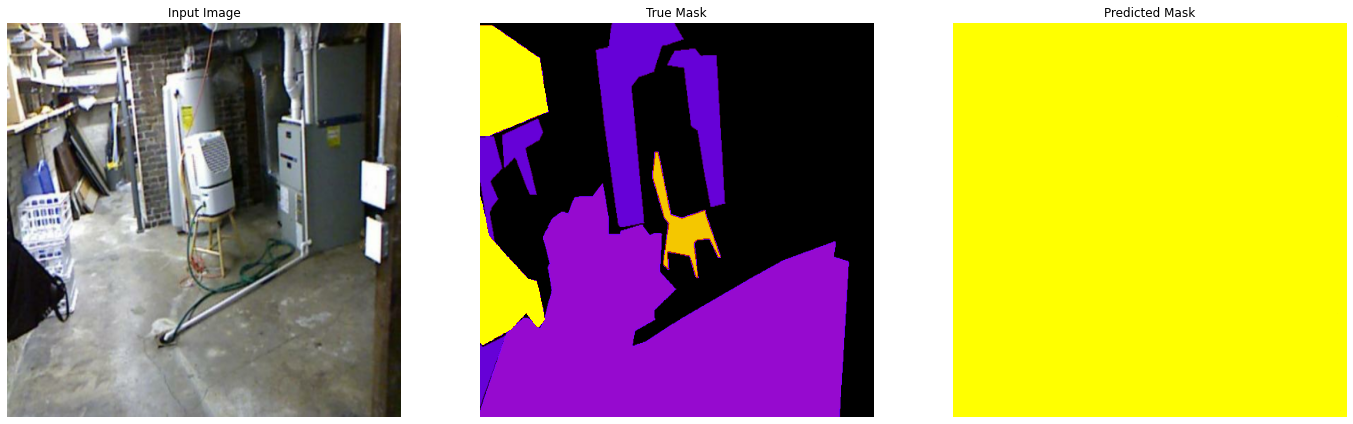

In [0]:
show_predictions()

In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

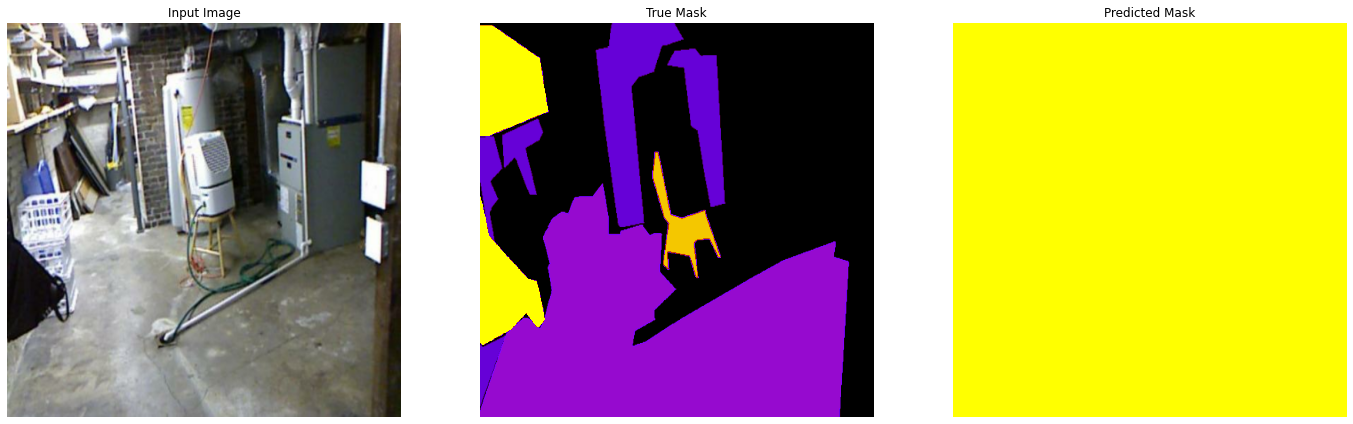


Sample Prediction after epoch 3


Epoch 00003: val_loss did not improve from 3.47789
57/57 [==============================] - 937s 16s/step - loss: 3.4732 - accuracy: 0.4989 - val_loss: 3.4788 - val_accuracy: 0.4990
Epoch 4/15
 6/57 [==>...........................] - ETA: 11:03 - loss: 3.4924 - accuracy: 0.4990

KeyboardInterrupt: ignored

In [0]:
EPOCHS = 15

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    str(checkpoint_path.resolve()) + "/resnetV50_sparsecategorical_fromlogitsTrue_accuracy_last_softmax.h5", 
    save_weights_only=True,
    save_best_only=True,
    verbose=1
)
 
cbck = [
    #tf.keras.callbacks.EarlyStopping(patience=2, monitor = 'val_loss'),
    #tf.keras.callbacks.TensorBoard(log_dir = log_path),
    DisplayCallback(),
    cp_callback,
]

model_history = model.fit(
    train_gen, 
    epochs=EPOCHS,
    steps_per_epoch=STEPS_TRAIN,
    validation_steps=STEPS_VAL,
    validation_data=val_gen,
    callbacks=cbck
)


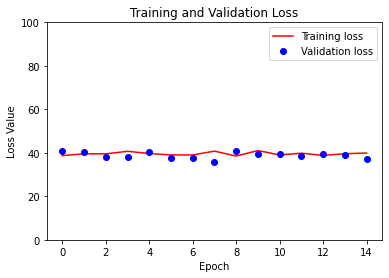

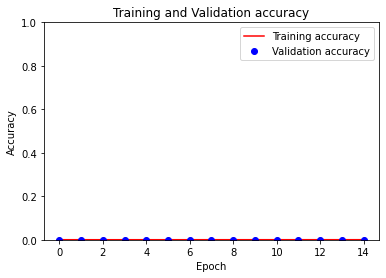

In [0]:
loss = model_history.history['loss']
acc = model_history.history['accuracy']
val_loss = model_history.history['val_loss']
val_acc = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
#LOSS
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 100])
plt.legend()

#ACCURACY
plt.figure()
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'bo', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()

plt.show()

In [0]:
#LOAD MODEL

#checkpoint_name = "/resnetV50_sparse_acc_generator.h5"
#checkpoint_name = "/resnetV50_sparse_miou_generator.h5"
checkpoint_name = "/resnetV50_sparse_acc_generator_last_softmax.h5"
model = unet_model(SIZE, OUTPUT_CHANNELS, down_stack, up_stack)

model.load_weights(str(checkpoint_path.resolve()) + checkpoint_name)

UNET MODEL


count: 0
i: 0


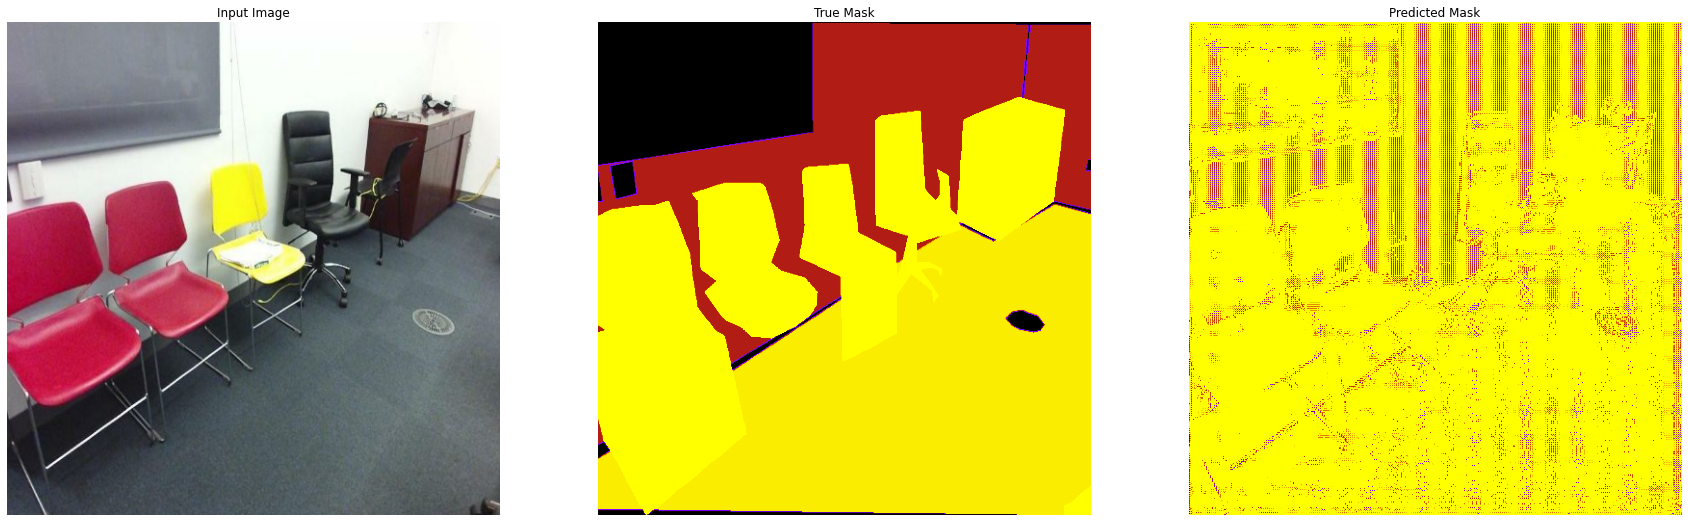

i: 1


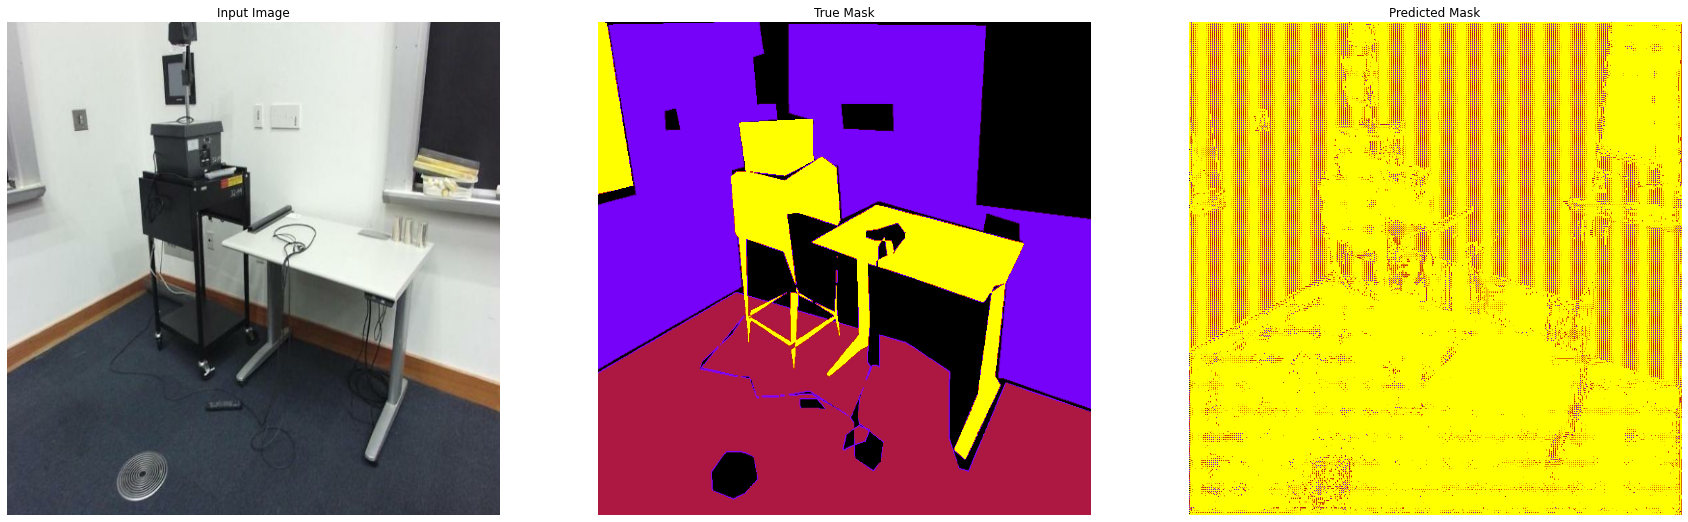

i: 2


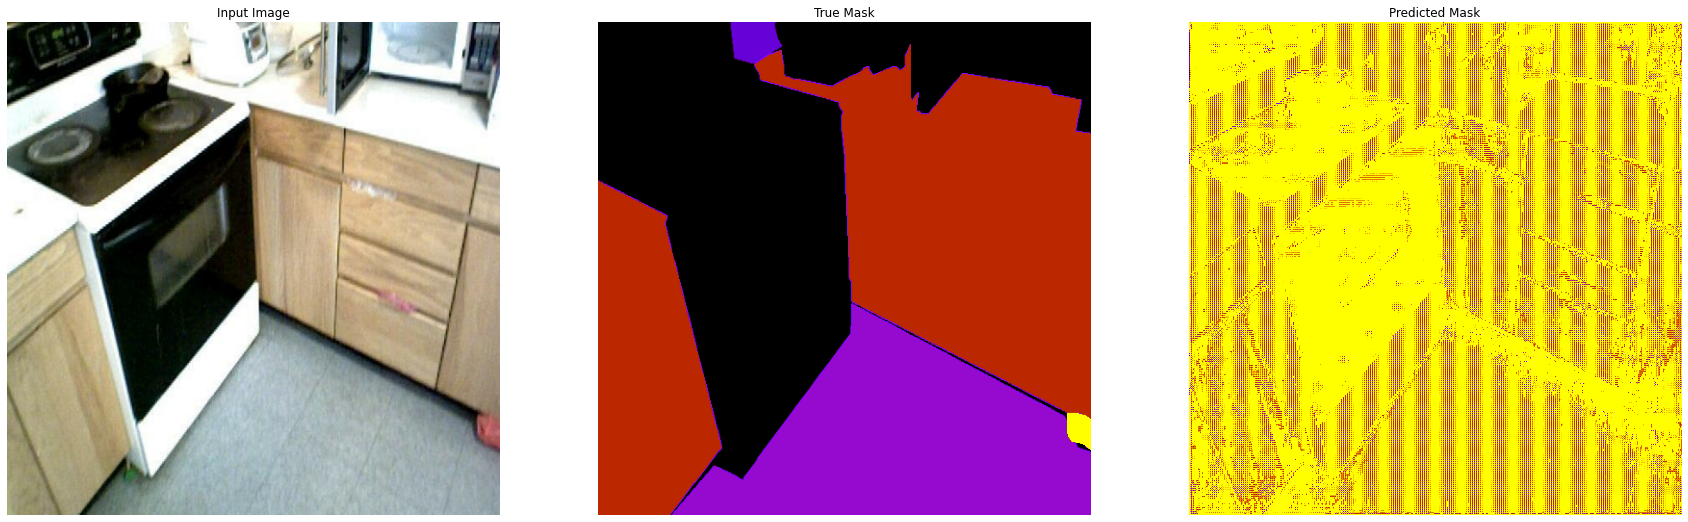

i: 3


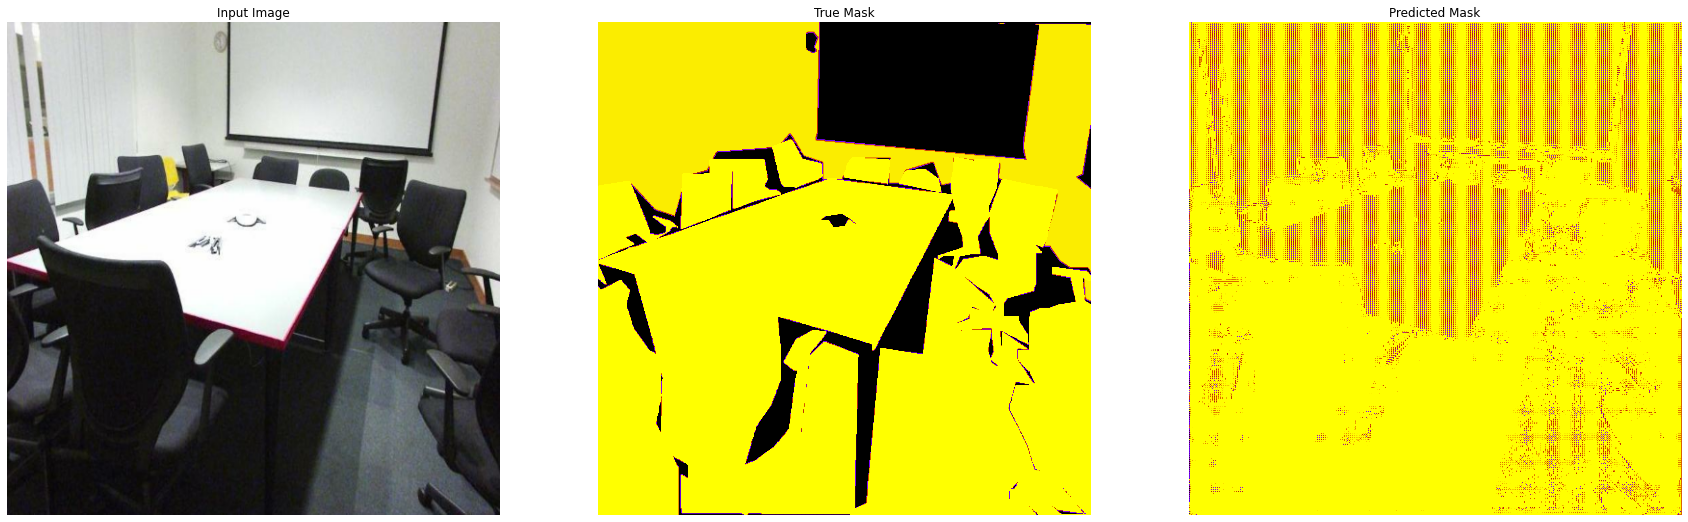

i: 4


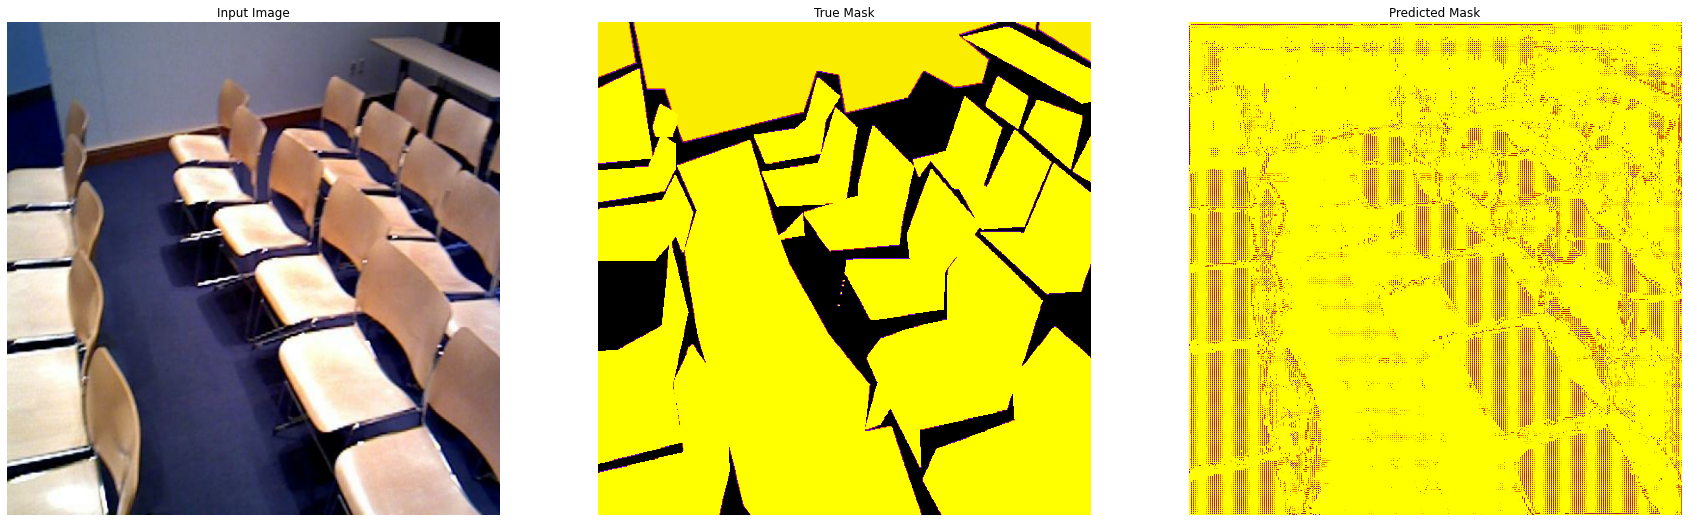

i: 5


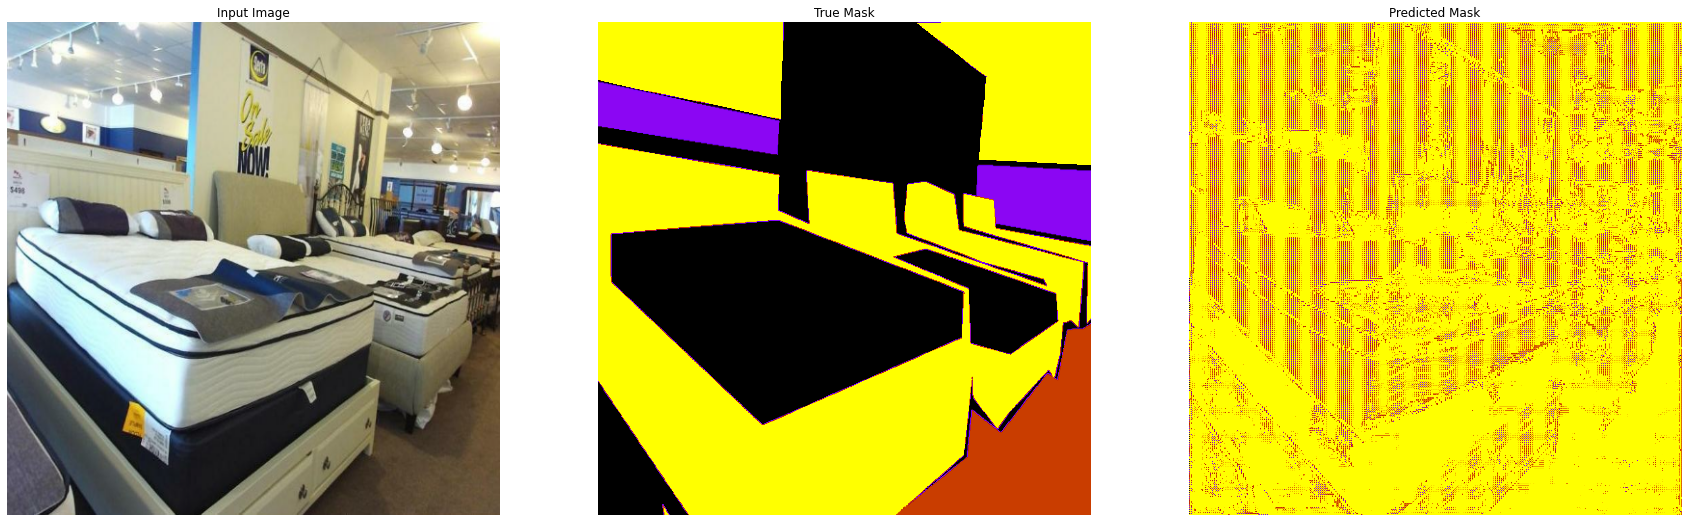

i: 6


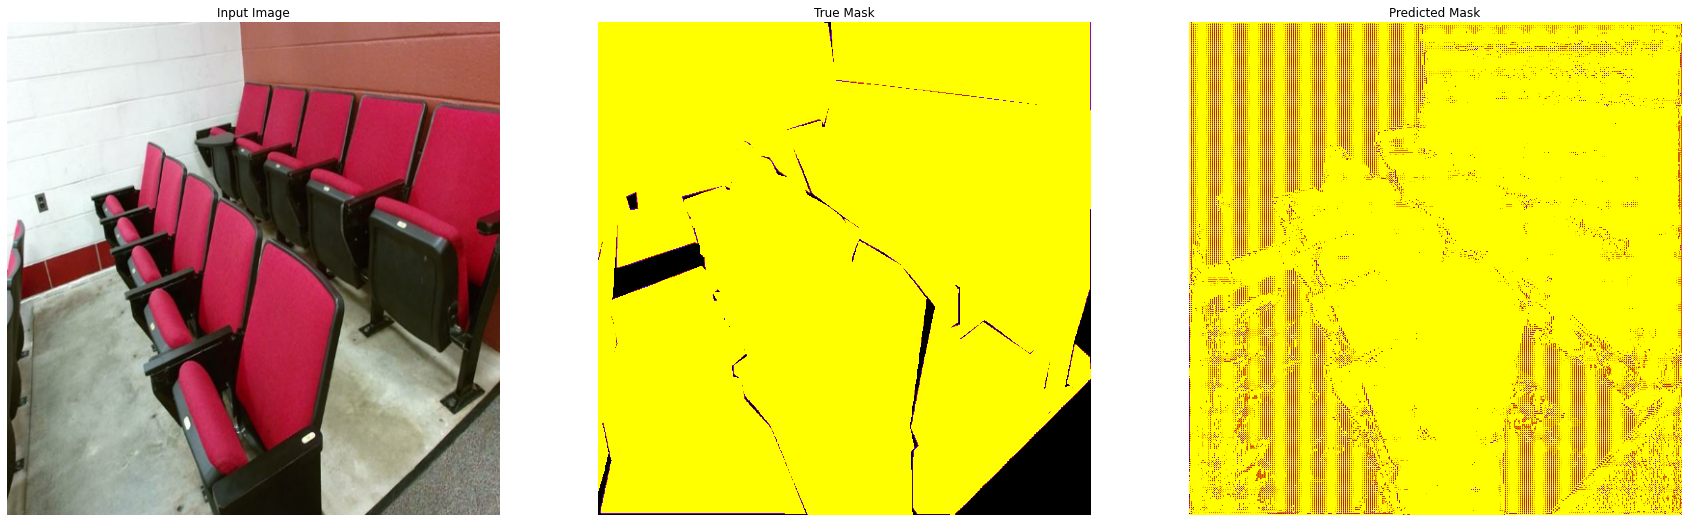

i: 7


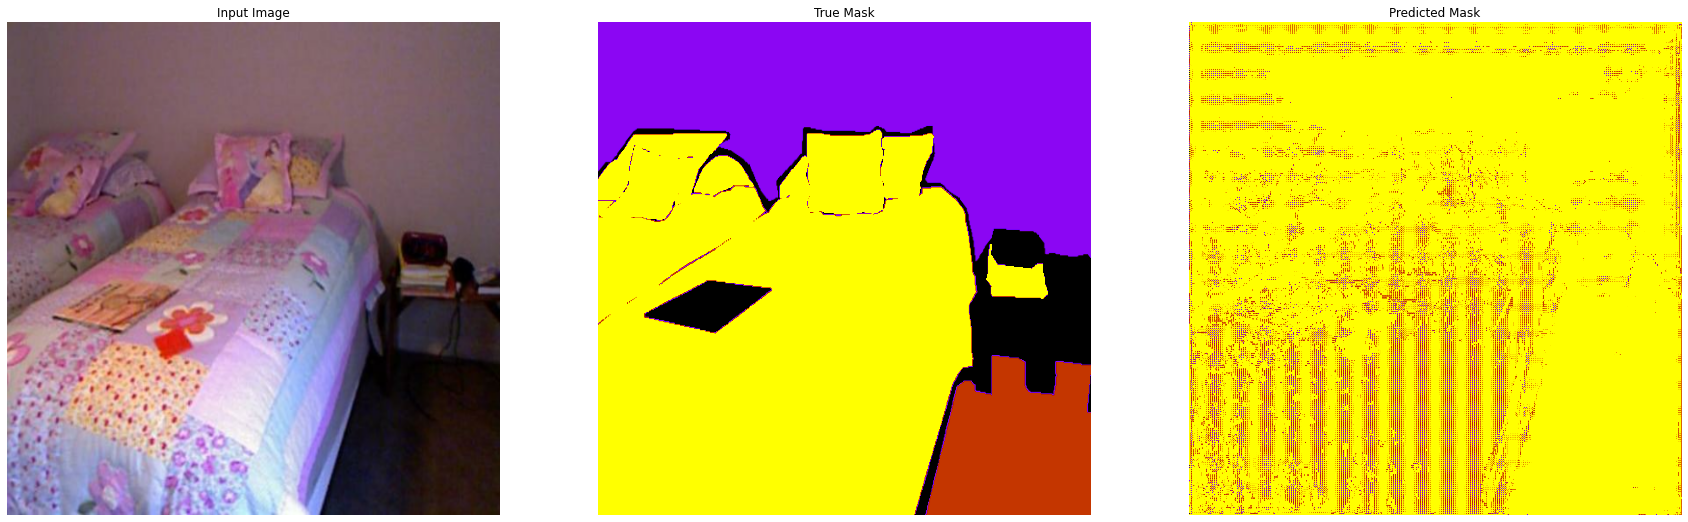

count: 1


In [0]:
show_predictions(train_gen)